In [1]:
# import

import numpy as np
import pandas as pd
import random

# keras
from tcn import TCN
from keras.layers import Dense, Input, Lambda, concatenate, UpSampling1D, Attention, GRU
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping
from keras.optimizers import *

# general
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from math import sqrt

import datetime

In [2]:
now = datetime.datetime.now
np.random.seed(1337)  # for reproducibility

In [3]:
timesteps = 240  # number of timesteps
nr = 90   # number of repetitions
n_dim = 117  # dimension of the data sequences

In [4]:
import DataViconLoad   # Import the data
Correct_data, Correct_label, Incorrect_data, Incorrect_label = DataViconLoad.load_data()

# Print the size of the data 
print(Correct_data.shape, 'correct sequences')
print(Correct_label.shape, 'correct labels')
print(Incorrect_data.shape, 'incorrect sequences')
print(Incorrect_label.shape, 'incorrect labels')

(90, 240, 117) correct sequences
(90, 1) correct labels
(90, 240, 117) incorrect sequences
(90, 1) incorrect labels


In [5]:
# Split the data into training and validation sets
# Training set: 60%
# Testing set: 20%
# Validation set: 20%

# Sample random indices
trainidx1 = random.sample(range(0,Correct_data.shape[0]),int(nr*0.6))
trainidx2 = random.sample(range(0,Incorrect_data.shape[0]),int(nr*0.6))

tempidx1 = np.setdiff1d(np.arange(0,nr,1),trainidx1)
tempidx2 = np.setdiff1d(np.arange(0,nr,1),trainidx2)

valididx1 = tempidx1[::2] 
valididx2 = tempidx1[1::2]

testidx1 = tempidx2[1::2]
testidx2 = tempidx2[::2]


# Training set: data and labels
train_x = np.concatenate((Correct_data[trainidx1,:,:],Incorrect_data[trainidx2,:,:]))
print(train_x.shape, 'training data')
train_y = np.concatenate((np.squeeze(Correct_label[trainidx1]),np.squeeze(Incorrect_label[trainidx2])))
print(train_y.shape, 'training labels')


# Testing set: data and labels
test_x = np.concatenate((Correct_data[testidx1,:,:],Incorrect_data[testidx2,:,:]))
print(test_x.shape, 'testing data')
test_y = np.concatenate((np.squeeze(Correct_label[testidx1]),np.squeeze(Incorrect_label[testidx2])))
print(test_y.shape, 'testing labels')

# Validation set: data and labels
valid_x = np.concatenate((Correct_data[valididx1,:,:],Incorrect_data[valididx2,:,:]))
print(valid_x.shape, 'validation data')
valid_y = np.concatenate((np.squeeze(Correct_label[valididx1]),np.squeeze(Incorrect_label[valididx2])))
print(valid_y.shape, 'validation labels')

(108, 240, 117) training data
(108,) training labels
(36, 240, 117) testing data
(36,) testing labels
(36, 240, 117) validation data
(36,) validation labels


In [6]:
# Reduce the data length by a factor of 2, 4, and 8 
# The reduced sequences will be used as inputs to the temporal pyramid subnetwork
train_x_2 = np.zeros((train_x.shape[0], int(train_x.shape[1]), train_x.shape[2]))
valid_x_2 = np.zeros(train_x_2.shape)
test_x_2 = np.zeros(train_x_2.shape)

train_x_4 = np.zeros((train_x.shape[0], int(train_x.shape[1]), train_x.shape[2]))
valid_x_4 = np.zeros(train_x_4.shape)
test_x_4 = np.zeros(train_x_4.shape)

train_x_8 = np.zeros((train_x.shape[0], int(train_x.shape[1]), train_x.shape[2]))
valid_x_8 = np.zeros(train_x_8.shape)
test_x_8 = np.zeros(train_x_8.shape)

train_x_2 = train_x[:,::,:]
valid_x_2 = valid_x[:,::,:]
test_x_2 = test_x[:,::,:]

train_x_4 = train_x[:,::,:]
valid_x_4 = valid_x[:,::,:]
test_x_4 = test_x[:,::,:]

train_x_8 = train_x[:,::,:]
valid_x_8 = valid_x[:,::,:]
test_x_8 = test_x[:,::,:]

In [7]:
# Code to re-order the 117 dimensional skeleton data from the Vicon optical tracker into trunk, left arm, right arm, left leg and right leg
def reorder_data(x):
    X_trunk = np.zeros((x.shape[0],x.shape[1],12))
    X_left_arm = np.zeros((x.shape[0],x.shape[1],18))
    X_right_arm = np.zeros((x.shape[0],x.shape[1],18))
    X_left_leg = np.zeros((x.shape[0],x.shape[1],21))
    X_right_leg = np.zeros((x.shape[0],x.shape[1],21))
    X_trunk =  np.concatenate((x[:,:,15:18], x[:,:,18:21], x[:,:,24:27], x[:,:,27:30]), axis = 2)
    X_left_arm = np.concatenate((x[:,:,81:84], x[:,:,87:90], x[:,:,93:96], x[:,:,99:102], x[:,:,105:108], x[:,:,111:114]), axis = 2)
    X_right_arm = np.concatenate((x[:,:,84:87], x[:,:,90:93], x[:,:,96:99], x[:,:,102:105], x[:,:,108:111], x[:,:,114:117]), axis = 2)  
    X_left_leg = np.concatenate((x[:,:,33:36], x[:,:,39:42], x[:,:,45:48], x[:,:,51:54], x[:,:,57:60], x[:,:,63:66], x[:,:,69:72]), axis = 2)
    X_right_leg = np.concatenate((x[:,:,36:39], x[:,:,42:45], x[:,:,48:51], x[:,:,54:57], x[:,:,60:63], x[:,:,66:69], x[:,:,72:75]), axis = 2)
    x_segmented = np.concatenate((X_trunk, X_right_arm, X_left_arm, X_right_leg, X_left_leg),axis = -1)
    return x_segmented

In [8]:
# Reorder the data dimensions to correspond to the five body parts
trainx =  reorder_data(train_x)
validx =  reorder_data(valid_x)
testx =  reorder_data(test_x)

trainx_2 =  reorder_data(train_x_2)
validx_2 =  reorder_data(valid_x_2)
testx_2 =  reorder_data(test_x_2)

trainx_4 =  reorder_data(train_x_4)
validx_4 =  reorder_data(valid_x_4)
testx_4 =  reorder_data(test_x_4)

trainx_8 =  reorder_data(train_x_8)
validx_8 =  reorder_data(valid_x_8)
testx_8 =  reorder_data(test_x_8)

In [9]:
def createTCNLayers(input, timesteps, n_dim):
   
    tcn_layer = TCN(input_shape=(timesteps, n_dim), nb_filters=12,kernel_size=3,nb_stacks=1,dilations=(1, 2, 4, 8, 16, 32),
        padding='causal',use_skip_connections=True,dropout_rate=0.007,return_sequences=True,
        activation='relu',kernel_initializer='he_normal',use_batch_norm=False,use_layer_norm=False,use_weight_norm=False)(input)
    return tcn_layer

In [10]:
def getTCNLayers(input_f, input_2, input_4, input_8, timesteps, n_dim1, n_dim2, ndim3):
    
    tcn_1 = createTCNLayers(input_f, timesteps, n_dim1)
    
    tcn_2 = createTCNLayers(input_2, timesteps, n_dim2)
    
    tcn_3 = createTCNLayers(input_4, timesteps, n_dim2)
        
    tcn_5 = createTCNLayers(input_8, timesteps, n_dim3)
    
    final_tcn = concatenate([tcn_1, tcn_2, tcn_3, tcn_5], axis=-1)
    
    return final_tcn

In [11]:
n_dim = 90 # dimension after segmenting the data into body parts
n_dim1 = 12 # trunk dimension
n_dim2 = 18 # arms dimension
n_dim3 = 21 # legs dimension

# Build the model ...

#### Full scale sequences
seq_input = Input(shape = (timesteps, n_dim), name = 'full_scale')

seq_input_trunk = Lambda(lambda x: x[:, :, 0:12])(seq_input)
seq_input_left_arm = Lambda(lambda x: x[:, :, 12:30])(seq_input)
seq_input_right_arm = Lambda(lambda x: x[:, :, 30:48])(seq_input)
seq_input_left_leg = Lambda(lambda x: x[:, :, 48:69])(seq_input)
seq_input_right_leg = Lambda(lambda x: x[:, :, 69:90])(seq_input)

#### Half scale sequences
seq_input_2 = Input(shape=(int(timesteps), n_dim), name='half_scale')

seq_input_trunk_2 = Lambda(lambda x: x[:, :, 0:12])(seq_input_2)
seq_input_left_arm_2 = Lambda(lambda x: x[:, :, 12:30])(seq_input_2)
seq_input_right_arm_2 = Lambda(lambda x: x[:, :, 30:48])(seq_input_2)
seq_input_left_leg_2 = Lambda(lambda x: x[:, :, 48:69])(seq_input_2)
seq_input_right_leg_2 = Lambda(lambda x: x[:, :, 69:90])(seq_input_2)

#### Quarter scale sequences
seq_input_4 = Input(shape=(int(timesteps), n_dim), name='quarter_scale')

seq_input_trunk_4 = Lambda(lambda x: x[:, :, 0:12])(seq_input_4)
seq_input_left_arm_4 = Lambda(lambda x: x[:, :, 12:30])(seq_input_4)
seq_input_right_arm_4 = Lambda(lambda x: x[:, :, 30:48])(seq_input_4)
seq_input_left_leg_4 = Lambda(lambda x: x[:, :, 48:69])(seq_input_4)
seq_input_right_leg_4 = Lambda(lambda x: x[:, :, 69:90])(seq_input_4)


#### Eighth scale sequences
seq_input_8 = Input(shape=(int(timesteps), n_dim), name='eighth_scale')

seq_input_trunk_8 = Lambda(lambda x: x[:, :, 0:12])(seq_input_8)
seq_input_left_arm_8 = Lambda(lambda x: x[:, :, 12:30])(seq_input_8)
seq_input_right_arm_8 = Lambda(lambda x: x[:, :, 30:48])(seq_input_8)
seq_input_left_leg_8 = Lambda(lambda x: x[:, :, 48:69])(seq_input_8)
seq_input_right_leg_8 = Lambda(lambda x: x[:, :, 69:90])(seq_input_8)

concat_trunk = getTCNLayers(seq_input_trunk, seq_input_trunk_2, seq_input_trunk_4, seq_input_trunk_8,
                            timesteps, n_dim1, n_dim2, n_dim3)
concat_left_arm = getTCNLayers(seq_input_left_arm, seq_input_left_arm_2, seq_input_left_arm_4, seq_input_left_arm_8,
                               timesteps, n_dim1, n_dim2, n_dim3)
concat_right_arm = getTCNLayers(seq_input_right_arm, seq_input_right_arm_2, seq_input_right_arm_4, seq_input_right_arm_8,
                               timesteps, n_dim1, n_dim2, n_dim3)
concat_left_leg = getTCNLayers(seq_input_left_leg, seq_input_left_leg_2, seq_input_left_leg_4, seq_input_left_leg_8,
                               timesteps, n_dim1, n_dim2, n_dim3)
concat_right_leg = getTCNLayers(seq_input_right_leg, seq_input_right_leg_2, seq_input_right_leg_4, seq_input_right_leg_8,
                               timesteps, n_dim1, n_dim2, n_dim3)

concat = concatenate([concat_trunk, concat_left_arm, concat_right_arm, concat_left_leg, concat_right_leg], axis=-1)

tcn_layer_final = TCN(nb_filters=12,kernel_size=3,nb_stacks=1,dilations=(1, 2, 4, 8),
        padding='same',use_skip_connections=True,dropout_rate=0.005,return_sequences=True,
        activation='relu',kernel_initializer='he_normal',use_batch_norm=False,use_layer_norm=False,
                      use_weight_norm=False)(concat)

tcn_layer_final_1 = TCN(nb_filters=8,kernel_size=2,nb_stacks=1,dilations=(1, 2, 4),
        padding='same',use_skip_connections=True,dropout_rate=0.005,return_sequences=True,
        activation='relu',kernel_initializer='he_normal',use_batch_norm=True,use_layer_norm=False,
                        use_weight_norm=False)(tcn_layer_final)

tcn_layer_final_2 = TCN(nb_filters=6,kernel_size=3,nb_stacks=1,dilations=(1, 2),
        padding='same',use_skip_connections=True,dropout_rate=0.005,return_sequences=False,
        activation='relu',kernel_initializer='he_normal',use_batch_norm=False,use_layer_norm=False,
                        use_weight_norm=False)(tcn_layer_final_1)

out = Dense(1, activation = 'sigmoid')(tcn_layer_final_2)

model = Model(inputs=[seq_input, seq_input_2, seq_input_4, seq_input_8], outputs=out)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 full_scale (InputLayer)        [(None, 240, 90)]    0           []                               
                                                                                                  
 half_scale (InputLayer)        [(None, 240, 90)]    0           []                               
                                                                                                  
 quarter_scale (InputLayer)     [(None, 240, 90)]    0           []                               
                                                                                                  
 eighth_scale (InputLayer)      [(None, 240, 90)]    0           []                               
                                                                                              

In [13]:
model.compile(optimizer=Adam(learning_rate=0.003), loss='mse')

In [14]:
t = now()
    
early_stopping = EarlyStopping(monitor='val_loss', patience = 40)

history = model.fit([trainx, trainx_2, trainx_4, trainx_8], train_y, batch_size=7, epochs=200, verbose=1, 
                validation_data=([validx, validx_2, validx_4, validx_8], valid_y), callbacks = [early_stopping])

print('Training time: %s' % (now() - t))

Epoch 1/200
16/16 [==============================] - 70s 923ms/step - loss: 0.0413 - val_loss: 0.0046
Epoch 2/200
16/16 [==============================] - 8s 497ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 3/200
16/16 [==============================] - 8s 508ms/step - loss: 0.0040 - val_loss: 0.0042
Epoch 4/200
16/16 [==============================] - 8s 491ms/step - loss: 0.0038 - val_loss: 0.0062
Epoch 5/200
16/16 [==============================] - 8s 504ms/step - loss: 0.0043 - val_loss: 0.0028
Epoch 6/200
16/16 [==============================] - 8s 491ms/step - loss: 0.0026 - val_loss: 0.0033
Epoch 7/200
16/16 [==============================] - 8s 499ms/step - loss: 0.0017 - val_loss: 0.0099
Epoch 8/200
16/16 [==============================] - 8s 480ms/step - loss: 0.0017 - val_loss: 0.0294
Epoch 9/200
16/16 [==============================] - 8s 495ms/step - loss: 0.0022 - val_loss: 0.0600
Epoch 10/200
16/16 [==============================] - 8s 483ms/step - loss: 0.0021 - val_l

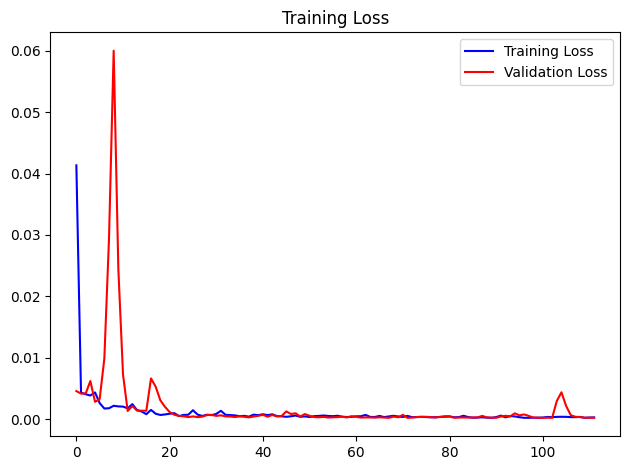

Training loss 0.00019083853112533689
Validation loss 0.00017658465367276222


In [15]:
# Plot the results
plt.figure(1)
plt.plot(history.history['loss'], 'b', label = 'Training Loss')
plt.title('Training Loss')
plt.plot(history.history['val_loss'], 'r', label = 'Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()
# Print the minimum loss
print("Training loss", np.min(history.history['loss']))
print("Validation loss",np.min(history.history['val_loss']))    

In [16]:
# Plot the prediction of the model for the training and validation sets
pred_train = model.predict([trainx, trainx_2, trainx_4, trainx_8])

pred_test = model.predict([testx, testx_2, testx_4, testx_8])

2/2 [==============================] - 0s 62ms/step


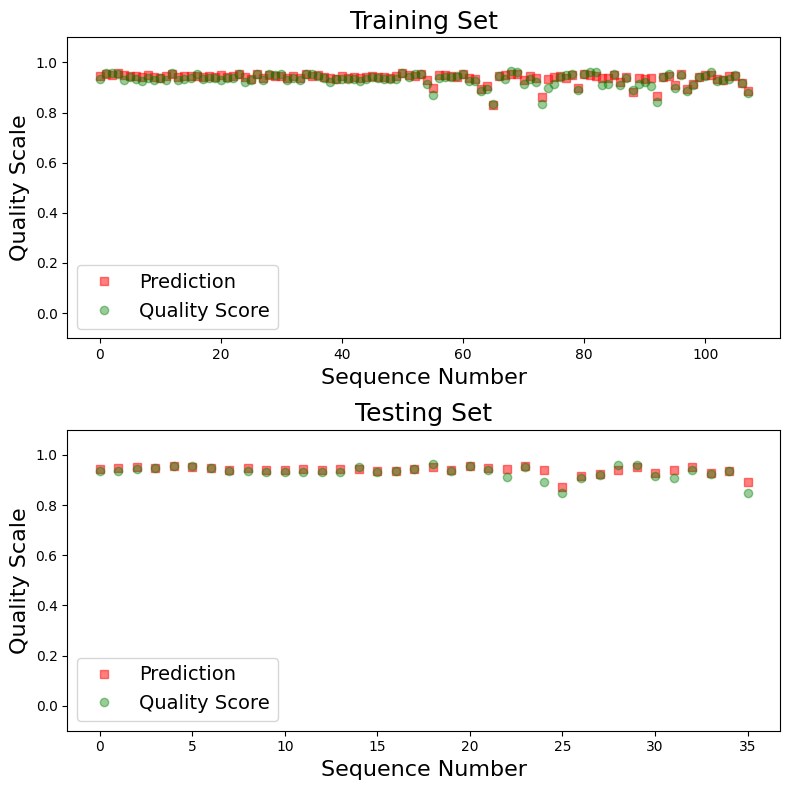

In [17]:
plt.figure(figsize = (8,8))
plt.subplot(2,1,1)
plt.plot(pred_train,'s', color='red', label='Prediction', linestyle='None', alpha = 0.5, markersize=6)
plt.plot(train_y,'o', color='green',label='Quality Score', alpha = 0.4, markersize=6)
plt.ylim([-0.1,1.1])
plt.title('Training Set',fontsize=18)
plt.xlabel('Sequence Number',fontsize=16)
plt.ylabel('Quality Scale',fontsize=16)
plt.legend(loc=3, prop={'size':14}) # loc:position
plt.subplot(2,1,2)
plt.plot(pred_test,'s', color='red', label='Prediction', linestyle='None', alpha = 0.5, markersize=6)
plt.plot(test_y,'o', color='green',label='Quality Score', alpha = 0.4, markersize=6)
plt.title('Testing Set',fontsize=18)
plt.ylim([-0.1,1.1])
plt.xlabel('Sequence Number',fontsize=16)
plt.ylabel('Quality Scale',fontsize=16)
plt.legend(loc=3, prop={'size':14}) # loc:position
plt.tight_layout()
plt.savefig('TCN_LR003_E200.png', dpi=300)
plt.show()

In [18]:
# Calculate the cumulative deviation and rms deviation for the validation set
test_dev = abs(np.squeeze(pred_test)-test_y)
# Cumulative deviation
mean_abs_dev = np.mean(test_dev)
# RMS deviation
rms_dev = sqrt(mean_squared_error(pred_test, test_y))
print('Mean absolute deviation:', mean_abs_dev)
print('RMS deviation:', rms_dev)

Mean absolute deviation: 0.010918482044537861
RMS deviation: 0.01593142537817346


In [19]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
#r2
score = r2_score(test_y, pred_test)
print("The accuracy of our model is {}%".format(round(score, 4) *100))
#
mae_score = mean_absolute_error(test_y, pred_test)
print("The Mean Absolute Error of our Model is {}".format(round(mae_score, 6)))
#
mse_score = mean_squared_error(test_y, pred_test)
print("The Mean Squared Error of our Model is {}".format(round(mae_score, 6)))
#
rmse_score = np.sqrt(mean_squared_error(test_y, pred_test))
print("The Root Mean Squared Error of our Model is {}".format(round(rmse_score, 6)))
#
ev_score = explained_variance_score(test_y, pred_test)
print("The EV Score of our Model is {}".format(round(ev_score, 6)))

The accuracy of our model is 61.919999999999995%
The Mean Absolute Error of our Model is 0.010918
The Mean Squared Error of our Model is 0.010918
The Root Mean Squared Error of our Model is 0.015931
The EV Score of our Model is 0.721055
